In [1]:
%cd ..

/home/broise/tmp_projects/fb_impact


## Model Definition

Now it’s time to start modelling. So, this is where it really depends on your use case and data set how you want to proceed. For example, if you are in an unsupervised context you can choose between an auto-encoder, PCA or clustering. Or if you are in a supervised context you have choice between different state-of-the-art machine learning and deep learning algorithms. But here are some guidelines which are required to follow:

 

- Choose, justify and apply a model performance indicator (e.g. F1 score, true positive rate, within cluster sum of squared error, …) to assess your model and justify the choice of an algorithm

- Implement your algorithm in at least one deep learning and at least one non-deep learning algorithm, compare and document model performance

- Apply at least one additional iteration in the process model involving at least the feature creation task and record impact on model performance (e.g. data normalizing, PCA, …)

Depending on the algorithm class and data set size you might choose specific technologies / frameworks to solve your problem. Please document all your decisions in the ADD (Architectural Decisions Document).

Once you think you have achieved a descent model performance save the notebook according to the process model’s naming convention and proceed to the model training task.



In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from IPython.display import clear_output
from typing import List
from app.src.models.architecture import Net

## Task 

We will try to predict the impact of a Facebook post based on other features

It is a regression task.


In [3]:
ds = pd.read_parquet("./data/processed/dataset_facebook.parquet")

In [4]:
ds[["like", "comment", "share"]].describe()

,like,comment,share
count,495.000000,495.000000,495.000000
mean,179.145455,7.557576,27.264646
std,324.412161,21.274384,42.656388
min,0.000000,0.000000,0.000000
25%,57.000000,1.000000,10.000000
50%,101.000000,3.000000,19.000000
75%,188.000000,7.000000,32.500000
max,5172.000000,372.000000,790.000000


In [5]:
def impact_score(ds):
    """
    This score tries to convey that a 'like' is a less meaningful interaction than a share, which is itself less meaningful than a comment (see the median of each of those values in the dataset)
    """
    comment_score = ds.comment.apply(lambda x: np.log(x + 0.00001))
    like_score = ds.like.apply(lambda x: np.log(x + 0.00001))
    share_score = ds.share.apply(lambda x: np.log(x + 0.00001))
    print(np.array([comment_score, like_score, share_score]))
    comment_score = preprocessing.MinMaxScaler().fit_transform(
        np.array(comment_score).reshape(-1, 1)
    )
    like_score = preprocessing.MinMaxScaler().fit_transform(
        np.array(like_score).reshape(-1, 1)
    )
    share_score = preprocessing.MinMaxScaler().fit_transform(
        np.array(share_score).reshape(-1, 1)
    )
    return (comment_score + like_score + share_score) / 3


ds["impact"] = impact_score(ds)

[[  1.38629686   1.60943991 -11.51292546 ... -11.51292546   1.38629686
    1.94591158]
 [  4.36944798   4.86753453   4.18965489 ...   3.9702921    4.5325996
    4.51085962]
 [  2.83321393   3.36729617   2.63905804 ...   3.09104291   2.89037231
    3.63758642]]


<AxesSubplot: >

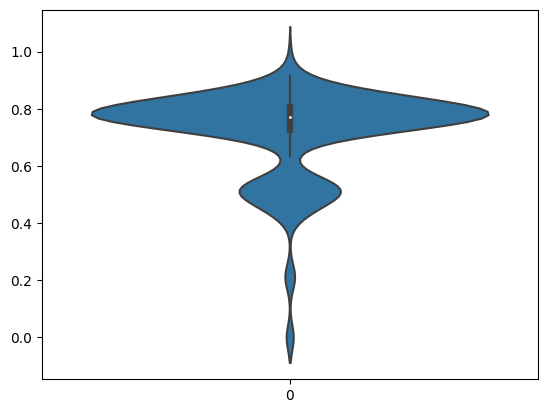

In [6]:
sns.violinplot(ds["impact"])

In [7]:
ds["impact"].describe()

count    495.000000
mean       0.720110
std        0.151855
min        0.000000
25%        0.725073
50%        0.770715
75%        0.807226
max        1.000000
Name: impact, dtype: float64

We define the "impact of a post" as the log of a metric we define. (The distribution of the total interaction being skewed it seem to be a good choice to mitigate the outliers)

We define the columns to use for training, We will use as feature everything that can be known prior to posting. so we remove all the columns that could be used as labels. 

In [8]:
training_features = [
    "Link",
    "Photo",
    "Status",
    "Video",
    "category_1",
    "category_2",
    "category_3",
    "Page total likes",
    "Post Month",
    "day_1",
    "day_2",
    "day_3",
    "day_4",
    "day_5",
    "day_6",
    "day_7",
    "Post Hour",
    "Paid",
    "Lifetime Post Total Reach",
    "Lifetime Post Total Impressions",
    "Lifetime Engaged Users",
    "Lifetime Post Consumers",
    "Lifetime Post Consumptions",
    "Lifetime Post Impressions by people who have liked your Page",
    "Lifetime Post reach by people who like your Page",
    "Lifetime People who have liked your Page and engaged with your post",
]

## We will split the dataset

In [9]:
ds_training = ds[training_features]

In [10]:
from sklearn import model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    ds_training, ds["impact"], random_state=42, train_size=0.8
)

In [11]:
print(len(x_train))
print(len(x_test))
assert len(x_train) == len(y_train)

396
99


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def metric_functions(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"mse": mse, "mae": mae, "r2": r2}

We will use 2 models, we will start with a simple decision tree addapted for regression.

In [13]:
from sklearn import tree

model = tree.DecisionTreeRegressor()
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [14]:
y_pred = model.predict(x_test)
metric_functions(y_test, y_pred)

{'mse': 0.019814241242375203,
 'mae': 0.08480174708672365,
 'r2': 0.2611246823102281}

<AxesSubplot: xlabel='impact', ylabel='Density'>

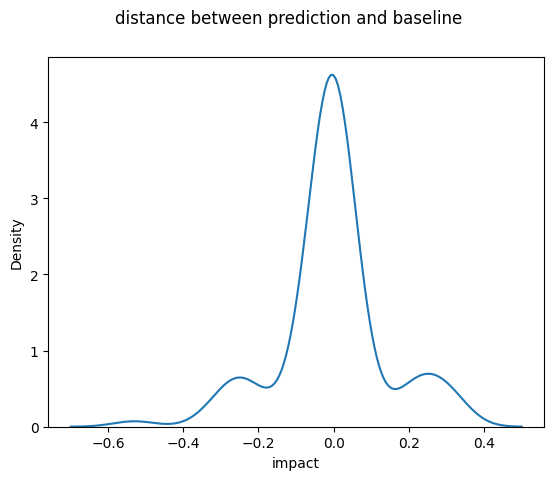

In [15]:
import matplotlib.pyplot as plt

plt.suptitle("distance between prediction and baseline")
sns.kdeplot(y_test - y_pred)

The model is already quite good, mean absolute error of 0.078 meaning the average l1 deviation from the label is .078

<AxesSubplot: xlabel='impact', ylabel='Density'>

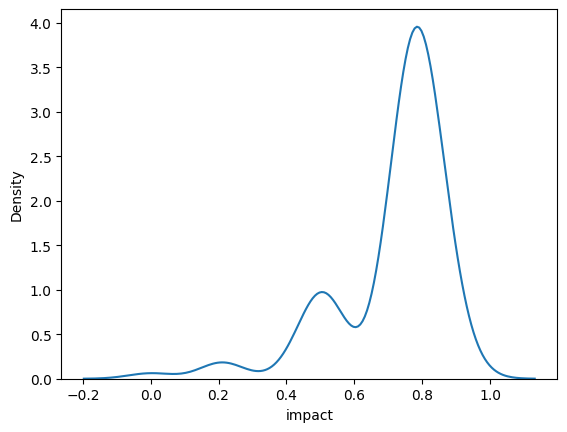

In [16]:
sns.kdeplot(y_test)

<AxesSubplot: ylabel='Density'>

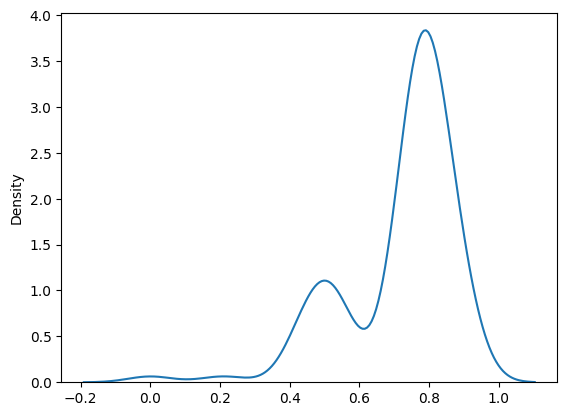

In [17]:
sns.kdeplot(y_pred)

The distribution of the prediction is quite similar to the prediction of the true labels

## Deep learning

We will train a simple neural network for this task using pytorch

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = len(x_train.columns)

In [19]:
model = Net(26)
model.to(device)
test_x = torch.Tensor(np.array(x_test)).to(device)
model(test_x)
clear_output()

In [20]:
test_x = torch.Tensor(np.array(x_train)).to(device)

In [21]:
test_x.shape

torch.Size([396, 26])

In [22]:
## Define the loss
loss = nn.L1Loss()
# loss = nn.MSELoss()

In [23]:
## We will create an optimizer
from torch.optim import Adam


def get_optimizer(model):
    return Adam(
        params=model.parameters(), betas=[0.9, 0.999], eps=1e-6, lr=7e-6
    )  ## I optimized a bit manually

In [26]:
import torch.utils.data as data
from loguru import logger
from IPython.display import clear_output
from tqdm.notebook import tqdm


def batching(iterable, batch_size=1):
    l = len(iterable)
    for ndx in range(0, l, batch_size):
        yield iterable[ndx : min(ndx + batch_size, l)]


def epoch_run(
    dataset,
    model,
    device,
    loss,
    optimizer,
    batch_size,
    final_metric=metric_functions,
    is_train=True,
    log_steps=50,
):
    model.to(device)
    dl = data.DataLoader(dataset, batch_size=batch_size)
    if is_train:
        model.train()
    else:
        model.eval()
    metrics = {"mse": [], "mae": [], "r2": []}
    cumul_loss = 0
    for i, (batch_x, batch_y) in enumerate(dl):
        if is_train:
            y = model(batch_x.to(device))
        else:
            with torch.no_grad():
                y = model(batch_x.to(device))
        if is_train:
            loss_ = loss(y, batch_y.reshape(-1, 1).to(device))
            cumul_loss += loss_
            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()
            if i % log_steps == log_steps - 1:
                logger.info(f"loss MSE:{cumul_loss/log_steps}")
                cumul_loss = 0
        if not is_train:
            for key, value in final_metric(
                batch_y.reshape(-1, 1).cpu(), y.cpu()
            ).items():
                metrics[key].append(value)
    if not is_train:
        metrics = {key: np.mean(value) for key, value in metrics.items()}
    else:
        metrics = {"mse": loss_.detach().cpu().numpy().item()}
    return metrics


x_train = torch.Tensor(np.array(x_train))
y_train = torch.Tensor(np.array(y_train))
dataset_train = data.TensorDataset(x_train, y_train)
x_test = torch.Tensor(np.array(x_test))
y_test = torch.Tensor(np.array(y_test))
dataset_test = data.TensorDataset(x_test, y_test)


def training(
    dataset_train,
    dataset_test,
    model,
    device,
    loss,
    optimizer,
    batch_size,
    epochs=10,
    metric_for_best_model="mse",
):
    eval_metrics = {}
    train_metrics = {}
    best_metric = 10
    for epoch in tqdm(range(epochs)):
        train_metrics[epoch] = epoch_run(
            dataset_train, model, device, loss, optimizer, batch_size
        )
        eval_metrics[epoch] = epoch_run(
            dataset_test, model, device, loss, optimizer, batch_size, is_train=False
        )
        if eval_metrics[epoch][metric_for_best_model] <= best_metric:
            best_metric = eval_metrics[epoch][metric_for_best_model]
            clear_output()
            logger.info(
                f"found new best model at epoch {epoch} with metrics {eval_metrics[epoch]}"
            )
            torch.save(dict(model.cpu().state_dict()), "./models/best_net")
    best_model = Net(26)
    best_model.load_state_dict(torch.load("./models/best_net"))
    return train_metrics, eval_metrics, best_metric, best_model


model = Net(26)
optimizer = get_optimizer(model)
train_metrics, eval_metrics, best_metric, best_model = training(
    dataset_train,
    dataset_test,
    model,
    device,
    loss,
    optimizer,
    batch_size=35,
    epochs=10000,
    metric_for_best_model="mae",
)

2023-06-07 16:08:06.145 | INFO     | __main__:training:63 - found new best model at epoch 9793 with metrics {'mse': 0.014067861, 'mae': 0.074988276, 'r2': 0.4625957625172658}


The lack of data seems to make it hard to find a really good model, but we have better MAE than non deep learning model. At some point we probably overfeat

0.026642929762601852


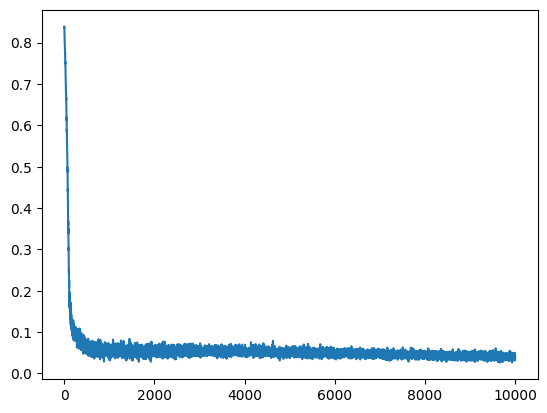

In [27]:
import matplotlib.pyplot as plt

train_mse = [i["mse"] for i in list(train_metrics.values())]
sns.lineplot(train_mse)
print(min(train_mse))

0.0138276


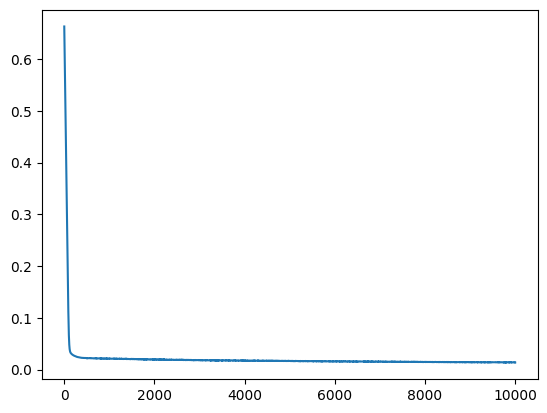

In [28]:
eval_mse = [i["mse"] for i in list(eval_metrics.values())]
sns.lineplot(eval_mse)

print(min(eval_mse))

In [29]:
error_dist = (best_model(x_test) - y_test.reshape(-1, 1)).detach().numpy()

<AxesSubplot: ylabel='Density'>

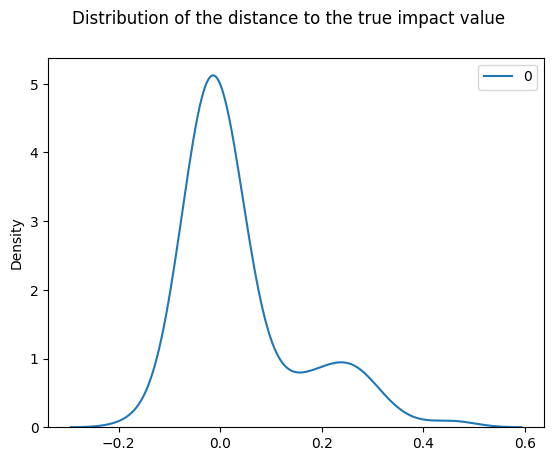

In [30]:
plt.suptitle("Distribution of the distance to the true impact value")
sns.kdeplot(error_dist)